# Data Migration 
Before using the database, logdata was storted to csv files into the `logs` directory. This Notebook creates a sqlite database `site.db` and writes the logdata to that file.

In [1]:
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from app import db, WalliStat, Campaign

C:\ProgramData\Anaconda3\envs\flask_env\lib\site-packages\flask_sqlalchemy\__init__.py:872: FSADeprecationWarning: SQLALCHEMY_TRACK_MODIFICATIONS adds significant overhead and will be disabled by default in the future.  Set it to True or False to suppress this warning.
  warnings.warn(FSADeprecationWarning(


In [2]:
db.create_all()

In [3]:
t = dt.datetime.now()    
next_hour = t.replace(second=0, microsecond=0, minute=0, hour=t.hour+1)
hourly = Campaign(id=0, title="hourly", start=next_hour, interval=dt.timedelta(seconds=3600))
hourly

Campaign(id:0, 'hourly' is active:None, start:2021-12-19 15:00:00, end:None, interval:1:00:00)

In [4]:
db.session.add(hourly)
db.session.commit()

In [5]:
path_ = os.path.join("..", "..", "logs")
for fn in os.listdir(path_):
    if fn.startswith("raw_2"):
        date_str = fn.split(".")[0].split("_")[1]
        df = pd.read_csv(os.path.join(path_, fn))
        df["datetime"] = [pd.to_datetime(date_str + " " + t).to_pydatetime() for t in df["time"]]
        dscr = df["datetime"].describe()
        print(fn, dscr["count"], dscr["first"], dscr["last"])

C:\Users\holge\AppData\Local\Temp/ipykernel_18116/272765373.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  dscr = df["datetime"].describe()


raw_2021-09-13.csv 1436 2021-09-13 00:00:46 2021-09-13 23:59:14
raw_2021-09-14.csv 1437 2021-09-14 00:00:14 2021-09-14 23:59:43
raw_2021-09-15.csv 1436 2021-09-15 00:00:44 2021-09-15 23:59:12
raw_2021-09-16.csv 1437 2021-09-16 00:00:12 2021-09-16 23:59:42
raw_2021-09-17.csv 1436 2021-09-17 00:00:42 2021-09-17 23:59:09
raw_2021-09-18.csv 1437 2021-09-18 00:00:09 2021-09-18 23:59:31
raw_2021-09-19.csv 1437 2021-09-19 00:00:31 2021-09-19 23:59:53
raw_2021-09-20.csv 1436 2021-09-20 00:00:53 2021-09-20 23:59:15
raw_2021-09-21.csv 1437 2021-09-21 00:00:15 2021-09-21 23:59:37
raw_2021-09-22.csv 1436 2021-09-22 00:00:37 2021-09-22 23:58:59
raw_2021-09-23.csv 1437 2021-09-23 00:00:00 2021-09-23 23:59:22
raw_2021-09-24.csv 1437 2021-09-24 00:00:22 2021-09-24 23:59:45
raw_2021-09-25.csv 1436 2021-09-25 00:00:45 2021-09-25 23:59:09
raw_2021-09-26.csv 1437 2021-09-26 00:00:09 2021-09-26 23:59:32
raw_2021-09-27.csv 1437 2021-09-27 00:00:32 2021-09-27 23:59:54
raw_2021-09-28.csv 1436 2021-09-28 00:00

## Try resampling on one example logfile

In [34]:
fn = "raw_2021-10-07.csv"
date_str = fn.split(".")[0].split("_")[1]
df = pd.read_csv(os.path.join("..", "..", "logs", fn))
df["datetime"] = [pd.to_datetime(date_str + " " + t).to_pydatetime() for t in df["time"]]
df.head()

,time,ver,charge_state,I_L1,I_L2,I_L3,Temp,V_L1,V_L2,V_L3,ext_lock,P,E_cyc_hb,E_cyc_lb,E_hb,E_lb,I_max,I_min,watchdog,standby,remote_lock,max_I_cmd,FailSafe_I,datetime
0,00:00:13,264,2,0,0,0,202,237,237,239,1,0,2,18424,5,2495,10,6,15000,4,1,100,100,2021-10-07 00:00:13
1,00:01:13,264,2,0,0,0,202,238,237,239,1,0,2,18424,5,2495,10,6,15000,4,1,100,100,2021-10-07 00:01:13
2,00:02:13,264,2,0,0,0,202,237,237,239,1,0,2,18424,5,2495,10,6,15000,4,1,100,100,2021-10-07 00:02:13
3,00:03:13,264,2,0,0,0,202,237,237,239,1,0,2,18424,5,2495,10,6,15000,4,1,100,100,2021-10-07 00:03:13
4,00:04:13,264,2,0,0,0,202,237,237,239,1,0,2,18424,5,2495,10,6,15000,4,1,100,100,2021-10-07 00:04:13


In [35]:
lowres = df.set_index("datetime").resample(dt.timedelta(seconds=3600)).first()
lowres.shape

(24, 23)

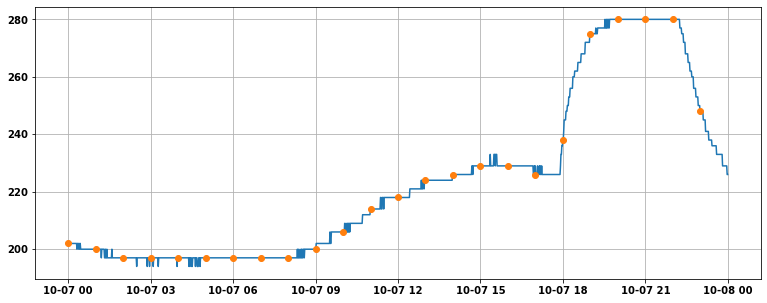

In [36]:
plt.figure(figsize=(13,5))
plt.plot(df["datetime"], df["Temp"])
plt.plot(lowres.index, lowres["Temp"], "o")
plt.grid();

## Resample on all logfiles

In [9]:
highres = pd.DataFrame()
path_ = os.path.join("..", "..", "logs")
for fn in os.listdir(path_):
    if fn.startswith("raw_2"):
        print(".", end="")
        date_str = fn.split(".")[0].split("_")[1]
        df = pd.read_csv(os.path.join(path_, fn))
        df["datetime"] = [pd.to_datetime(date_str + " " + t).to_pydatetime() for t in df["time"]]
        df.drop("time", axis=1, inplace=True)
        highres = pd.concat([highres, df], ignore_index=True)
highres.shape

..................................................................................................

(139336, 23)

In [10]:
highres.set_index("datetime", inplace=True)
highres.shape


(139336, 22)

In [11]:
lowres = highres.resample(dt.timedelta(seconds=3600)).first()
lowres.shape

(2341, 22)

Some plausibility plots

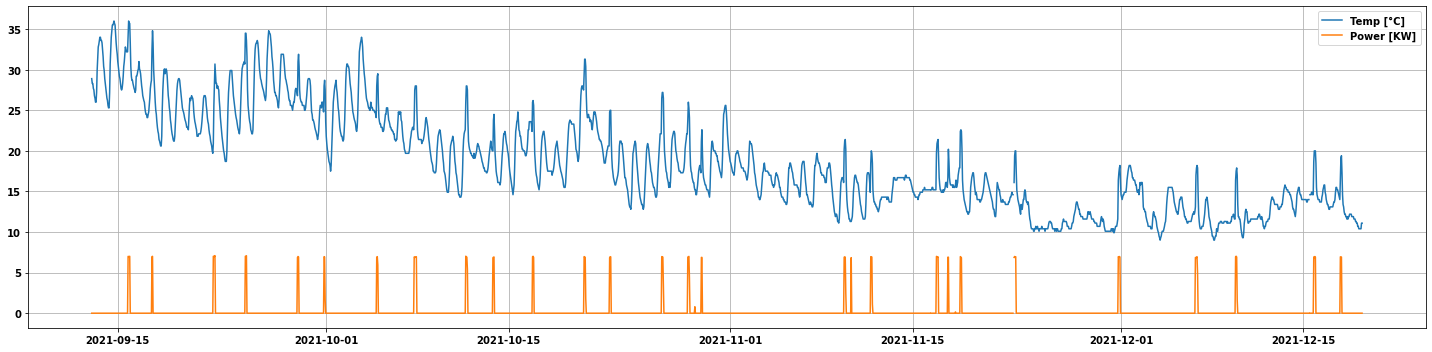

In [12]:
plt.figure(figsize=(20,5))
plt.plot(lowres.index, lowres["Temp"]/10., label="Temp [°C]")
plt.plot(lowres.index, lowres["P"]/1000., label="Power [KW]")
plt.grid(), plt.legend(), plt.tight_layout();

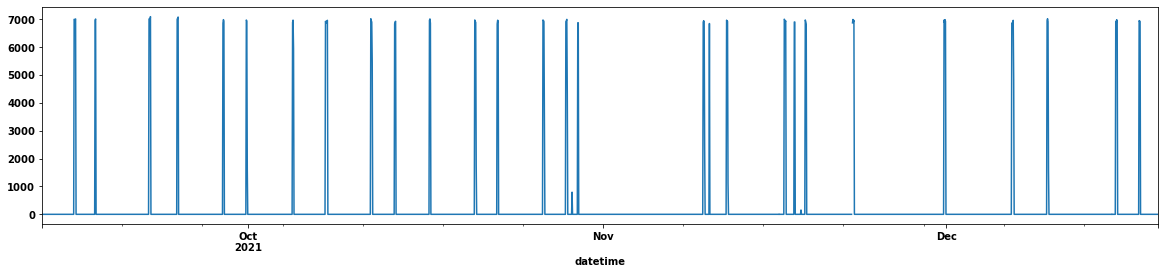

In [13]:
lowres["P"].plot(figsize=(20,4));

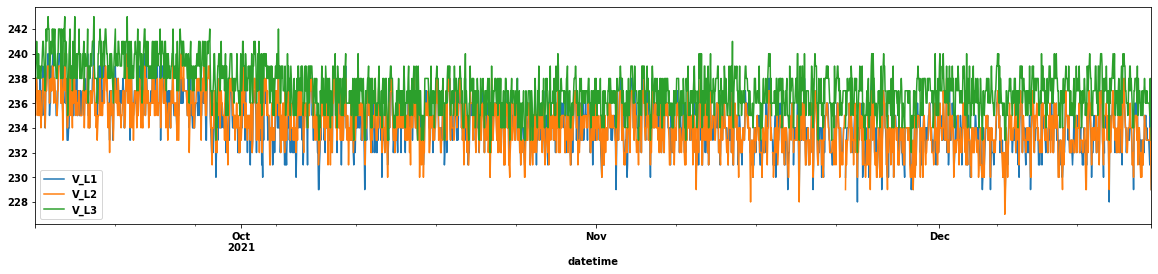

In [14]:
lowres[["V_L1", "V_L2", "V_L3"]].plot(figsize=(20,4));

In [15]:
lowres.charge_state.value_counts()

2.0    1853
5.0     385
7.0     100
Name: charge_state, dtype: int64

## Write lowres data to database ``site.db``

In [16]:
for index, row in lowres.reset_index().iterrows():
    row["campaign_id"] = 0   # hourly campaign
    ws = WalliStat.from_series(row)
    db.session.add(ws)
db.session.commit()

Exception: int() argument must be a string, a bytes-like object or a number, not 'NaTType'
arg 'series': datetime        2021-11-16 09:00:00
ver                             NaT
charge_state                    NaT
I_L1                            NaT
I_L2                            NaT
I_L3                            NaT
Temp                            NaT
V_L1                            NaT
V_L2                            NaT
V_L3                            NaT
ext_lock                        NaT
P                               NaT
E_cyc_hb                        NaT
E_cyc_lb                        NaT
E_hb                            NaT
E_lb                            NaT
I_max                           NaT
I_min                           NaT
watchdog                        NaT
standby                         NaT
remote_lock                     NaT
max_I_cmd                       NaT
FailSafe_I                      NaT
campaign_id                       0
Name: 1545, dtype: object
Excep

In [17]:
ws

WalliStat(id:2341-->campaign.id:0, 2021-12-19 12:00:00: 11.1°C, 0W)